In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import seaborn as sns
from pycbc.detector import Detector
from pycbc.inference import io, models
import matplotlib as mpl
import matplotlib.pyplot as plt
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# PyCBC inference model

In [2]:
def maxsnr(path):
    fp = io.loadfile(path,'r')
    cp = fp.read_config_file()
    data = fp.read_data()
    psds = fp.read_psds()
    model = models.read_from_config(cp, data=data, psds=psds)
    samples = fp.read_samples(list(fp['samples'].keys()))
    maxlidx = samples['loglikelihood'].argmax()
    maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}
    model.update(**maxlparams)
    #model.loglikelihood
    return (2*model.loglr)**0.5

In [3]:
maxsnr('./cpnest-shortstride/srate1024220/4ogcringdown_output/samples_files/H1L1V1-INFERENCE_GW150914_4-1126259200-400.hdf')

11.844275756021915

In [4]:
maxsnr('./cpnest-shortstride/srate1024220_221/4ogcringdown_output/samples_files/H1L1V1-INFERENCE_GW150914_4-1126259200-400.hdf')

13.257382193159682

# Plot waveform

In [5]:
path = './cpnest-shortstride/srate1024220/4ogcringdown_output/samples_files/H1L1V1-INFERENCE_GW150914_4-1126259200-400.hdf'
#path = './cpnest-shortstride/srate1024220_221/4ogcringdown_output/samples_files/H1L1V1-INFERENCE_GW150914_4-1126259200-400.hdf'
fp = io.loadfile(path,'r')
cp = fp.read_config_file()
data = fp.read_data()
psds = fp.read_psds()
    
# now let's load the model
model = models.read_from_config(cp, data=data, psds=psds)

# let's get the maximum likelihood point
samples = fp.read_samples(list(fp['samples'].keys()))
maxlidx = samples['loglikelihood'].argmax()
maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}

In [6]:
model.current_stats

{'logjacobian': nan,
 'logprior': nan,
 'loglikelihood': nan,
 'maxl_polarization': nan,
 'maxl_logl': nan}

In [7]:
# get the loglikelihood of these points
model.update(**maxlparams)
model.loglikelihood

-450390.1754207299

In [8]:
model.current_stats

{'logjacobian': nan,
 'logprior': nan,
 'loglikelihood': -450390.1754207299,
 'maxl_polarization': 0.30818426431611584,
 'maxl_logl': -450387.76138816087}

In [9]:
# get the matched-filter SNR
print((2*model.loglr)**0.5)

11.844281387691975


In [10]:
gated_wfs = model.get_gated_waveforms()
gated_data = model.get_gated_data()

In [11]:
pol = model.current_stats['maxl_polarization']
data = {}
for detname in gated_wfs:
        det = Detector(detname)
        fp, fc = det.antenna_pattern(model.current_params['ra'],
                                     model.current_params['dec'],
                                     pol,
                                     model.current_params['tc'])
        hp, hc = gated_wfs[detname]
        h = fp*hp + fc*hc
        data[detname] = h

In [12]:
gated_wfs = model.whiten(data, 1)

In [13]:
# get the gated, whitened maxL waveform and plot it against
# the whitened data

# whiten them
#gated_wfs = model.whiten(gated_wfs, 1)
gated_data = model.whiten(gated_data, 1)
# convert to the time domain
gated_wfs = {ifo: d.to_timeseries() for ifo, d in gated_wfs.items()}
gated_data = {ifo: d.to_timeseries() for ifo, d in gated_data.items()}

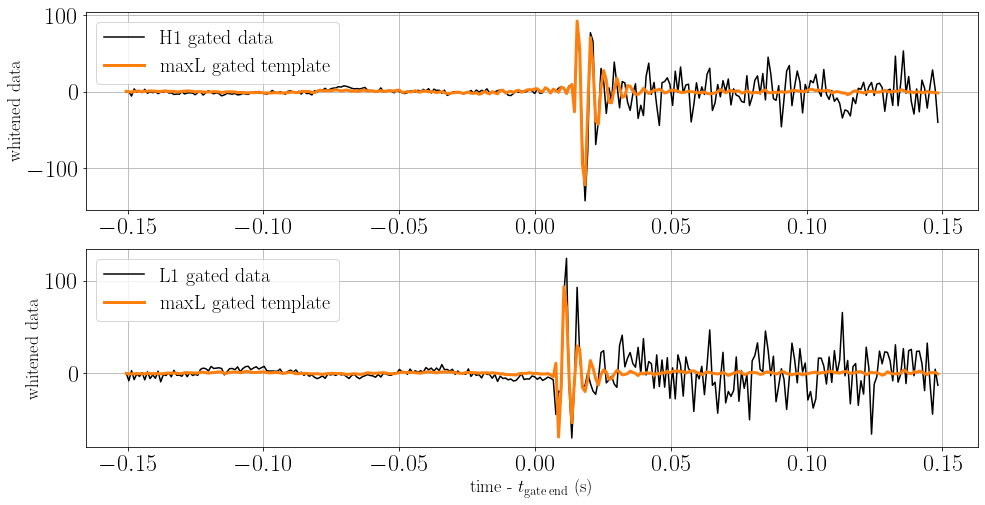

In [14]:
fig, axes = plt.subplots(nrows=2, figsize=(16,8))
for ii, ifo in enumerate(gated_wfs):
    ax = axes[ii]
    # we'll plot w.r.t. the geocentric end gate time
    t_gate_end = model.current_params['t_gate_end']
    d = gated_data[ifo].time_slice(t_gate_end-0.15, t_gate_end+0.15)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='black', label='{} gated data'.format(ifo))
    # plot the waveform
    d = gated_wfs[ifo].time_slice(t_gate_end-0.15, t_gate_end+0.15)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='C1', lw=3, label='maxL gated template')
    ax.legend()
    if ii == 1:
        ax.set_xlabel(r'time - $t_{\rm{gate\,end}}$ (s)', fontsize=18)

    ax.set_ylabel('whitened data', fontsize=18)
fig.show()

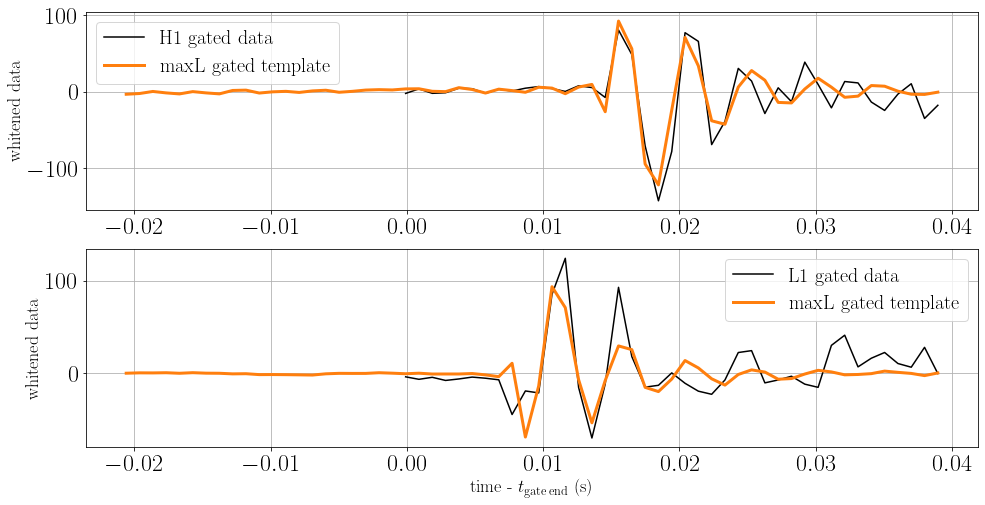

In [15]:
fig, axes = plt.subplots(nrows=2, figsize=(16,8))
for ii, ifo in enumerate(gated_wfs):
    ax = axes[ii]
    # we'll plot w.r.t. the geocentric end gate time
    t_gate_end = model.current_params['t_gate_end']
    d = gated_data[ifo].time_slice(t_gate_end-0., t_gate_end+0.04)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='black', label='{} gated data'.format(ifo))
    # plot the waveform
    d = gated_wfs[ifo].time_slice(t_gate_end-0.02, t_gate_end+0.04)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='C1', lw=3, label='maxL gated template')
    ax.legend()
    if ii == 1:
        ax.set_xlabel(r'time - $t_{\rm{gate\,end}}$ (s)', fontsize=18)

    ax.set_ylabel('whitened data', fontsize=18)
fig.show()

# Input the PyRing maxL parameters to PyCBC

In [172]:
pr221 = pd.read_csv('./pyring/t1/GW150914_PROD1_Kerr_221_0M/Nested_sampler/posterior.dat',sep=' ')
pr221.columns = [pr221.columns[(i+1)%len(pr221.columns)] for i in range(len(pr221.columns))]
pr221 = pr221.drop(columns='#')

In [173]:
pr221

psi         Mf        af   cosiota    A2220_1    A2220_2  \
0      0.077279  87.901819  0.901389 -0.283842  34.405815  13.571231   
1      0.718684  52.815935  0.216653 -0.236272  27.917913  32.546161   
2      0.359984  78.312866  0.660995 -0.619173  37.614324   4.374274   
3      0.410738  70.392786  0.588129 -0.210656  41.460341   7.073865   
4      2.567113  86.312187  0.763675 -0.325109  21.781356  13.597464   
...         ...        ...       ...       ...        ...        ...   
11746  3.098159  69.828397  0.669223 -0.733573  47.097983  10.455491   
11747  1.114151  76.542439  0.791006 -0.719365  23.106120   9.295474   
11748  0.501789  71.004587  0.672766 -0.393461  14.893725  18.574909   
11749  0.911802  75.437095  0.774501 -0.107038   1.928424  24.337708   
11750  2.412152  73.938578  0.756238 -0.693182  38.464272  11.359968   

         A2221_1    A2221_2  phi2220_1  phi2220_2  phi2221_1  phi2221_2  \
0      12.155639   0.868654   5.800510   2.891680   1.236086   3.917747   
1      46.880096  25.775058   2.106267   2.693647   2.140105   5.850114   
2      37.012387   8.236135   2.398203   2.486415   1.380287   3.538785   
3      44.584363  27.434443   1.485696   3.820858   0.015526   6.192904   
4      36.231076   6.168049   2.135197   3.522516   1.804932   1.058227   
...          ...        ...        ...        ...        ...        ...   
11746  24.816851  14.346998   2.468142   4.280067   1.282195   1.566035   
11747   3.473257  12.864051   0.215267   2.132666   2.574467   5.822677   
11748  41.163350  26.416567   3.034698   3.061604   0.500159   0.247771   
11749   7.224688  33.785979   1.260646   2.435374   5.364193   5.990902   
11750  14.137606  14.130232   4.766919   5.840111   0.911386   3.183693   

               logL  logPrior  
0      38762.440340       0.0  
1      38762.523070       0.0  
2      38763.223646       0.0  
3      38763.683551       0.0  
4      38763.846697       0.0  
...             ...       ...  
11746  38779.060569       0.0  
11747  38779.079351       0.0  
11748  38779.084495       0.0  
11749  38779.093636       0.0  
11750  38779.156149       0.0  

[11751 rows x 14 columns]

In [174]:
maxlparams

{'final_mass': 77.24744487714477,
 'final_spin': 0.7933603506892939,
 'inclination': 1.6825838838701077,
 'logamp220': -19.7822043130713,
 'phi220': 3.7922217890395102,
 'amp221': 1.3510697733636268,
 'phi221': 0.22855808380252726}

In [175]:
len(pr221)

11751

In [191]:
i=len(pr221)-1

pyring_maxlparams={'final_mass':pr221['Mf'][i],
             'final_spin':pr221['af'][i],
             'inclination':np.arccos(pr221['cosiota'][i]),
             'logamp220':np.log10(pr221['A2220_1'][i]*1e-21),
             'phi220':pr221['phi2220_1'][i],
             'amp221':pr221['A2221_1'][i]/pr221['A2220_1'][i],
             'phi221':pr221['phi2221_1'][i]}

In [192]:
pyring_maxlparams={'final_mass':pr221['Mf'][i],
             'final_spin':pr221['af'][i],
             'inclination':np.arccos(pr221['cosiota'][i]),
             'logamp220':np.log10(pr221['A2220_2'][i]*1e-21),
             'phi220':pr221['phi2220_2'][i],
             'amp221':pr221['A2221_2'][i]/pr221['A2220_2'][i],
             'phi221':pr221['phi2221_2'][i]}

In [193]:
model.current_params

{'final_mass': 73.93857806103193,
 'final_spin': 0.7562375653530676,
 'inclination': 2.336690215745493,
 'logamp220': -19.944622897254806,
 'phi220': 5.840110918521309,
 'amp221': 1.2438619720829298,
 'phi221': 3.1836931210248056,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4077973,
 'ra': 2.242743237442093,
 'dec': -1.2242535126007028,
 'toffset': -0.0004833333333333334,
 'lmns': 222.0,
 't_gate_start': 1126259460.407314,
 't_gate_end': 1126259462.407314,
 'tc': 1126259462.4063141,
 'amp220': 1.1359967862325129e-20}

In [194]:
#model.static_params['ra'] = pyring_maxlparams['ra']
#model.static_params['dec'] = pyring_maxlparams['dec']
model.update(**pyring_maxlparams)
model.current_params

{'final_mass': 73.93857806103193,
 'final_spin': 0.7562375653530676,
 'inclination': 2.336690215745493,
 'logamp220': -19.944622897254806,
 'phi220': 5.840110918521309,
 'amp221': 1.2438619720829298,
 'phi221': 3.1836931210248056,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4077973,
 'ra': 2.242743237442093,
 'dec': -1.2242535126007028,
 'toffset': -0.0004833333333333334,
 'lmns': 222.0}

In [195]:
model.loglikelihood

-450447.120800314

In [196]:
model.lognl

-450460.3190972682

In [197]:
model.current_stats['maxl_polarization']

1.2138686329185786

In [198]:
model.loglr

13.198296954215039

In [199]:
(2*model.loglr)**0.5

5.137761565938038

# Only get SNR ~ 5?